# Fuzzy Pooling Implementation

In [1]:
import numpy as np

# Sample Patch Pij
patch = np.array([
    [1, 2, 3],
    [4, 5, 1],
    [2, 3, 4]
])


# Parameters for triangular membership functions
r_max = 6
d = r_max / 2
c = d / 3
a = r_max / 4
m = d
b = m + a
r = d
q = r + r_max / 4

# Defining fuzzy membership functions for "small," "medium," and "large" values
def small_membership(x):
    """Membership function for 'small' values."""
    if x > d:
        return 0
    elif c <= x <= d:
        return (d - x) / (d - c)
    else:
        return 1

def medium_membership(x):
    """Membership function for 'medium' values."""
    if x <= a or x >= b:
        return 0
    elif a < x <= m:
        return (x - a) / (m - a)
    elif m < x < b:
        return (b - x) / (b - m)

def large_membership(x):
    """Membership function for 'large' values."""
    if x < r:
        return 0
    elif r <= x <= q:
        return (x - r) / (q - r)
    else:
        return 1

In [1]:
# Applying the membership functions on the patch
small_fuzzified = np.vectorize(small_membership)(patch)
medium_fuzzified = np.vectorize(medium_membership)(patch)
large_fuzzified = np.vectorize(large_membership)(patch)

# Fuzzy aggregation
small_score = np.sum(small_fuzzified)
medium_score = np.sum(medium_fuzzified)
large_score = np.sum(large_fuzzified)

# Selecting the dominant fuzzy set
if medium_score >= small_score and medium_score >= large_score:
    dominant_fuzzified = medium_fuzzified
elif small_score >= medium_score and small_score >= large_score:
    dominant_fuzzified = small_fuzzified
else:
    dominant_fuzzified = large_fuzzified

# Defuzzification using Center of Gravity (CoG) to get the final pooled value
numerator = np.sum(dominant_fuzzified * patch)
denominator = np.sum(dominant_fuzzified)

if denominator != 0:
    pooled_value = numerator / denominator
else:
    pooled_value = 0  # Fallback if all memberships are zero

print("Original Patch:")
print(patch)
print("\nFuzzy Membership Values (Small):")
print(small_fuzzified)
print("\nFuzzy Membership Values (Medium):")
print(medium_fuzzified)
print("\nFuzzy Membership Values (Large):")
print(large_fuzzified)
print("\nDominant Fuzzy Set (chosen for pooling):")
print(dominant_fuzzified)
print("\nPooled Value (after defuzzification):")
print(pooled_value)


Original Patch:
[[1 2 3]
 [4 5 1]
 [2 3 4]]

Fuzzy Membership Values (Small):
[[1.  0.5 0. ]
 [0.  0.  1. ]
 [0.5 0.  0. ]]

Fuzzy Membership Values (Medium):
[[0 0 1]
 [0 0 0]
 [0 1 0]]

Fuzzy Membership Values (Large):
[[0 0 0]
 [0 1 0]
 [0 0 0]]

Dominant Fuzzy Set (chosen for pooling):
[[1.  0.5 0. ]
 [0.  0.  1. ]
 [0.5 0.  0. ]]

Pooled Value (after defuzzification):
1.3333333333333333


# Fuzzy Pooling in CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Loading and preprocessing the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
class FuzzyPoolingLayer(layers.Layer):
    def __init__(self, pool_size=(2, 2)):
        super(FuzzyPoolingLayer, self).__init__()
        self.pool_size = pool_size

    def small_membership(self, x, d, c):
        return tf.where(x < c, 1.0, tf.where(x <= d, (d - x) / (d - c), 0.0))

    def medium_membership(self, x, a, m, b):
        return tf.where(x < a, 0.0, tf.where(x <= m, (x - a) / (m - a), tf.where(x < b, (b - x) / (b - m), 0.0)))

    def large_membership(self, x, r, q):
        return tf.where(x < r, 0.0, tf.where(x <= q, (x - r) / (q - r), 1.0))

    def call(self, inputs):
        pool_height, pool_width = self.pool_size
        d, c = 3.0, 1.0  # for 'small' range
        a, m, b = 1.5, 3.0, 4.5  # for 'medium' range
        r, q = 3.0, 4.5  # for 'large' range

        # Extract patches
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, pool_height, pool_width, 1],
            strides=[1, pool_height, pool_width, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )

        # Reshape patches for processing
        batch_size, out_height, out_width, num_channels = tf.shape(inputs)[0], tf.shape(patches)[1], tf.shape(patches)[2], inputs.shape[-1]
        patch_depth = pool_height * pool_width
        patches = tf.reshape(patches, (-1, patch_depth, num_channels))

        # Calculate membership for each patch
        small_values = self.small_membership(patches, d, c)
        medium_values = self.medium_membership(patches, a, m, b)
        large_values = self.large_membership(patches, r, q)

        # Aggregate fuzzy scores
        small_score = tf.reduce_sum(small_values, axis=1)
        medium_score = tf.reduce_sum(medium_values, axis=1)
        large_score = tf.reduce_sum(large_values, axis=1)

        # Select dominant fuzzy set
        scores = tf.stack([small_score, medium_score, large_score], axis=1)
        max_score_idx = tf.argmax(scores, axis=1)

        # Reshape max_score_idx to align with patches
        max_score_idx = tf.reshape(max_score_idx, (-1, 1, num_channels))

        # Select appropriate values based on dominant fuzzy set
        selected_values = tf.where(
            tf.equal(max_score_idx, 0),
            small_values,
            tf.where(
                tf.equal(max_score_idx, 1),
                medium_values,
                large_values
            )
        )

        # Defuzzification using Center of Gravity
        numerator = tf.reduce_sum(selected_values * patches, axis=1)
        denominator = tf.reduce_sum(selected_values, axis=1)
        pooled_values = tf.where(denominator != 0, numerator / denominator, tf.zeros_like(numerator))

        return tf.reshape(pooled_values, (batch_size, out_height, out_width, num_channels))

    # def compute_output_shape(self, input_shape):
    #     batch_size, height, width, channels = input_shape
    #     output_height = height // self.pool_size[0]
    #     output_width = width // self.pool_size[1]
    #     return (batch_size, output_height, output_width, channels)

In [ ]:
def create_optimized_max_pooling_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_optimized_fuzzy_pooling_model():
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
        FuzzyPoolingLayer(pool_size=(2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def compile_and_train(model, x_train, y_train, x_test, y_test, model_name):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=3, batch_size=32, validation_data=(x_test, y_test))
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"{model_name} Test accuracy: {test_acc:.4f}")
    return history, test_loss, test_acc

Training Optimized Max Pooling Model:
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.8600 - loss: 0.4386 - val_accuracy: 0.9801 - val_loss: 0.0634
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9804 - loss: 0.0637 - val_accuracy: 0.9851 - val_loss: 0.0480
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9862 - loss: 0.0430 - val_accuracy: 0.9827 - val_loss: 0.0512
313/313 - 2s - 6ms/step - accuracy: 0.9827 - loss: 0.0512
Optimized Max Pooling Model Test accuracy: 0.9827

Training Optimized Fuzzy Pooling Model:
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 103s 54ms/step - accuracy: 0.8762 - loss: 0.4028 - val_accuracy: 0.9820 - val_loss: 0.0587
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 104s 56ms/step - accuracy: 0.9811 - loss: 0.0649 - val_accuracy: 0.9840 - val_loss: 0.0539
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - accuracy: 0.9868 - loss: 0.0417 - val_accuracy: 0.9860 - val_loss: 0.0416
313/313 - 6s - 19ms/step

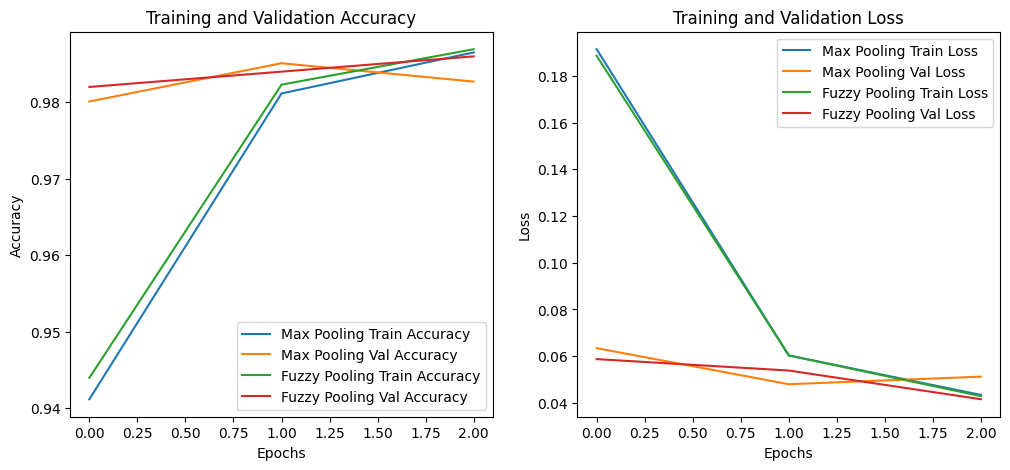


Final Test Results:
Max Pooling Model - Test Loss: 0.0512, Test Accuracy: 0.9827
Fuzzy Pooling Model - Test Loss: 0.0416, Test Accuracy: 0.9860


In [2]:
max_pooling_model = create_optimized_max_pooling_model()
fuzzy_pooling_model = create_optimized_fuzzy_pooling_model()

print("Training Optimized Max Pooling Model:")
max_pooling_history, max_pooling_test_loss, max_pooling_test_acc = compile_and_train(
    max_pooling_model, x_train, y_train, x_test, y_test, "Optimized Max Pooling Model"
)

print("\nTraining Optimized Fuzzy Pooling Model:")
fuzzy_pooling_history, fuzzy_pooling_test_loss, fuzzy_pooling_test_acc = compile_and_train(
    fuzzy_pooling_model, x_train, y_train, x_test, y_test, "Optimized Fuzzy Pooling Model"
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(max_pooling_history.history['accuracy'], label='Max Pooling Train Accuracy')
plt.plot(max_pooling_history.history['val_accuracy'], label='Max Pooling Val Accuracy')
plt.plot(fuzzy_pooling_history.history['accuracy'], label='Fuzzy Pooling Train Accuracy')
plt.plot(fuzzy_pooling_history.history['val_accuracy'], label='Fuzzy Pooling Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(max_pooling_history.history['loss'], label='Max Pooling Train Loss')
plt.plot(max_pooling_history.history['val_loss'], label='Max Pooling Val Loss')
plt.plot(fuzzy_pooling_history.history['loss'], label='Fuzzy Pooling Train Loss')
plt.plot(fuzzy_pooling_history.history['val_loss'], label='Fuzzy Pooling Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

print("\nFinal Test Results:")
print(f"Max Pooling Model - Test Loss: {max_pooling_test_loss:.4f}, Test Accuracy: {max_pooling_test_acc:.4f}")
print(f"Fuzzy Pooling Model - Test Loss: {fuzzy_pooling_test_loss:.4f}, Test Accuracy: {fuzzy_pooling_test_acc:.4f}")
